In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
manualSeed = 123
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [3]:
data_dir = "/kaggle/input/hindi-mnist/Hindi-MNIST/train"
model_save_path = "/kaggle/working/cgan_hindi_mnist.pt"
animation_save_path = "/kaggle/working/cgan_animation.mp4"
training_plot_save_path = "/kaggle/working/train_plot.png"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
lr = 0.0002
beta1 = 0.5
batch_size = 64
noise_dim = 100
workers = 2
num_epochs = 5
classes = 10
# Monitor Progress
progress = list()
fixed_noise = torch.randn(100, noise_dim, device=device)
fixed_labels = torch.Tensor([[i]*10 for i in range(10)]).view(100,).int().to(device)

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, classes) -> None:
        super(Discriminator, self).__init__()
        self.classes = classes

        self.embedding = nn.Sequential(
            nn.Embedding(classes, 100),
            nn.Linear(100, 1*64*64)
        )

        conv_1 = self.conv_block(4, 64)
        conv_2 = self.conv_block(64, 128)
        conv_3 = self.conv_block(128, 256)
        conv_4 = self.conv_block(256, 512)

        self.classifier = nn.Sequential(
            conv_1,
            conv_2,
            conv_3,
            conv_4,
            nn.Conv2d(512, 1024, (5, 5), 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (5, 5), 2, 2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    
    def forward(self, x, label):
        label_embedding = self.embedding(label).view(-1, 1, 64, 64)
        comb_latent_vector = torch.concat((x, label_embedding), dim=1)
        output = self.classifier(comb_latent_vector)
        return output

In [6]:
class Generator(nn.Module):
    def __init__(self, classes):
        super(Generator, self).__init__()
        self.classes = classes

        self.embedding = nn.Sequential(
            nn.Embedding(classes, 100),
            nn.Linear(100, 8*8)
        )

        self.latent_vector = nn.Sequential(
            nn.Linear(100, 512*8*8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        upsample_1 = self.upsample_block(513, 256, 1)
        upsample_2 = self.upsample_block(256, 128, 1)
        upsample_3 = self.upsample_block(128, 64, 1)

        self.conv_model = nn.Sequential(
            upsample_1,
            upsample_2,
            upsample_3,
            nn.Conv2d(64, 3, (1, 1), 1, 0),
            nn.Tanh()
        )
    
    def upsample_block(self, in_channels, out_channels, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, (4, 4), 2, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x, label):
        latent_vector = self.latent_vector(x).view(-1, 512, 8, 8)
        label_embedding = self.embedding(label).view(-1, 1, 8, 8)
        comb_latent_vector = torch.concat((latent_vector, label_embedding), dim = 1)
        output = self.conv_model(comb_latent_vector)
        return output

In [7]:
# custom weights initialization
# Reference (PyTorch Tutorials)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
dataset = datasets.ImageFolder(root=data_dir,
                               transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

dataloader = data.DataLoader(dataset, 
                             batch_size=batch_size,
                             shuffle=True, 
                             num_workers=workers)

In [9]:
disc_net = Discriminator(classes)
gen_net = Generator(classes)
disc_net.to(device)
gen_net.to(device)
disc_net.apply(weights_init)
gen_net.apply(weights_init)

Generator(
  (embedding): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=64, bias=True)
  )
  (latent_vector): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(

In [10]:
criterion = nn.BCELoss()

disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(beta1, 0.999))
gen_optimizer = optim.Adam(gen_net.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        real_labels = data[1].to(device)
        num_images = real_images.size(0)
        
        real_target = torch.ones(num_images,).to(device)
        fake_target = torch.zeros(num_images,).to(device)
        
        # Training the discriminator
        # Train Discriminator on Real Images and Fake Images
        disc_net.zero_grad()

        real_output = disc_net(real_images, real_labels).view(-1)
        disc_err_real = criterion(real_output, real_target)
        
        # Conditional Noise
        noise = torch.randn(num_images, noise_dim, device=device)
        noise_labels = torch.randint(0, classes, (num_images, ), device=device)

        fake = gen_net(noise, noise_labels)

        fake_output = disc_net(fake.detach(), noise_labels).view(-1)
        disc_err_fake = criterion(fake_output, fake_target)

        disc_err = (disc_err_real + disc_err_fake)/2
        disc_err.backward()
        disc_optimizer.step()

        # Training the Generator
        # Steps:
        # 1. Get Discriminator Predictions on Fake Images
        # 2. Calculate loss
        gen_net.zero_grad()
        
        output = disc_net(fake, noise_labels).view(-1)

        gen_err = criterion(output, real_target)
        gen_err.backward()
        gen_optimizer.step()

        # Training Update
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {disc_err.item()}\tLoss_G: {gen_err.item()}"
            )

        # Tracking loss
        G_losses.append(gen_err.item())
        D_losses.append(disc_err.item())

        # Tracking Generator Progress
        if (iters % 10 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = gen_net(fixed_noise, fixed_labels).detach().cpu()
            progress.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/266]	Loss_D: 0.7395462989807129	Loss_G: 1.0489280223846436
[0/5][50/266]	Loss_D: 0.3959703743457794	Loss_G: 1.3331546783447266
[0/5][100/266]	Loss_D: 0.3123405873775482	Loss_G: 1.5041239261627197
[0/5][150/266]	Loss_D: 0.4944750666618347	Loss_G: 0.9612898826599121
[0/5][200/266]	Loss_D: 0.4579263925552368	Loss_G: 1.2586264610290527
[0/5][250/266]	Loss_D: 0.3601597547531128	Loss_G: 1.3710103034973145
[1/5][0/266]	Loss_D: 0.3369591236114502	Loss_G: 1.5956714153289795
[1/5][50/266]	Loss_D: 0.2221633791923523	Loss_G: 1.9550806283950806
[1/5][100/266]	Loss_D: 0.1895737498998642	Loss_G: 2.248289108276367
[1/5][150/266]	Loss_D: 0.18706639111042023	Loss_G: 2.1991066932678223
[1/5][200/266]	Loss_D: 0.10956026613712311	Loss_G: 2.4196105003356934
[1/5][250/266]	Loss_D: 0.11830856651067734	Loss_G: 2.576968193054199
[2/5][0/266]	Loss_D: 0.11488695442676544	Loss_G: 2.8998379707336426
[2/5][50/266]	Loss_D: 0.08223699033260345	Loss_G: 2.836935043334961
[2/5][100/266]	

In [12]:
# Save generator
torch.save(gen_net, model_save_path)

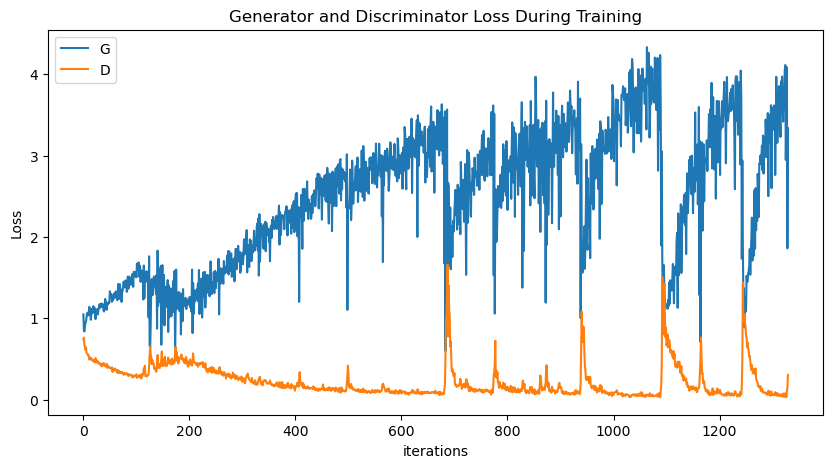

In [13]:
# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

In [14]:
# Progress Animation
fig2 = plt.figure(figsize=(10, 10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()